In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
import re
from sklearn.metrics import accuracy_score,f1_score, ConfusionMatrixDisplay,roc_curve, precision_score, recall_score

In [3]:
df =pd.read_csv('archive (1)\Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

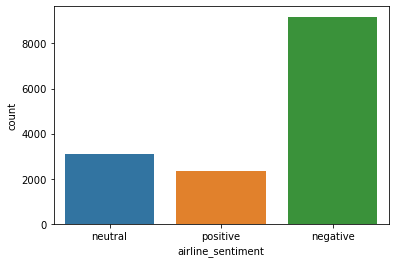

In [6]:

sn.countplot(x=df['airline_sentiment'])

**Labels are imbalance as more than half are negative**

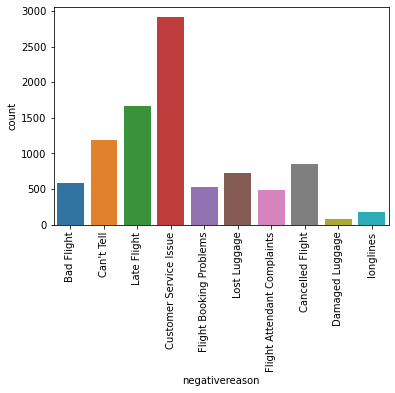

In [7]:
sn.countplot(x=df['negativereason'])
plt.xticks(rotation=90);

**customer service is most common issue**

In [8]:
df = df[['text','airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


**we only need text and sentiments from data**

In [9]:
df.isna().sum()

text                 0
airline_sentiment    0
dtype: int64

No Missing data

In [10]:
df['airline_sentiment']=df['airline_sentiment'].replace(['negative', 'neutral','positive'], [1, 0,2])

**Data cleaning**

In [11]:
def clean_text(text):
   
    text = str(text).lower() # convert text to lowercase
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text) # Remove URl and tags
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove punctuation
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['text'] = df['text'].apply(clean_text)

**Splitting data into feature X and target y**

In [12]:
X = df['text']
y = df['airline_sentiment']

**Train Test split**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
#X_train

**Tranformed the Text into float**

In [14]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

**Model 1 Support Vector Classifier**

In [15]:
model1 = SVC()
model1.fit(X_train,y_train)
y_pred=model1.predict(X_test)


In [16]:
print('Accuracy =',model1.score(X_test, y_test))
print("precision =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

Accuracy = 0.7778688524590164
precision = 0.7712009443069517
recall = 0.6505077912859268
f1 score = 0.6886893345365306


In [17]:
mod = GridSearchCV(estimator=model1,
                param_grid={'C':[0.001, 0.01, 0.1, 1, 10],
              'kernel':['linear','poly','rbf','sigmoid'],
              'gamma':['scale','auto',0.001, 0.01, 0.1, 1, 10]},
                cv=3)


In [18]:
#mod.fit(X_train, y_train);
#pd.DataFrame(mod.cv_results_)

**Model 2 Desicion Tree**

In [19]:
model2= DecisionTreeClassifier()
model2.fit(X_train,y_train)
y_pred=model2.predict(X_test)

In [20]:
print('Accuracy =',model2.score(X_test, y_test))
print("precesion =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

Accuracy = 0.6546448087431694
precesion = 0.5698219230254558
recall = 0.557412527268342
f1 score = 0.5629959526430115


In [21]:
mod = GridSearchCV(estimator=model2,
                   param_grid = {'criterion':['gini','entropy','log_loss'],
           'max_features':['sqrt','log2', None],
           'max_depth':[None,5,6,7,8,9,10,11,12,13,14,15]},
            cv=3)

In [22]:
#mod.fit(X_train, y_train);
#pd.DataFrame(mod.cv_results_)

**Model 3 Random forest**

In [23]:
model3= RandomForestClassifier()

In [24]:
model3.fit(X_train,y_train)
#y_pred=model3.predict(X_test)

RandomForestClassifier()

In [25]:
print(model3.score(X_test, y_test))
print("precesion =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

0.7527322404371585
precesion = 0.5698219230254558
recall = 0.557412527268342
f1 score = 0.5629959526430115


In [26]:
#mod = GridSearchCV(estimator=model3,
#                   param_grid = {'criterion':['gini','entropy','log_loss'],
#           'max_features':['sqrt','log2', None],
#            'n_estimators':[50,100,150,200,250,300,400],
#            'max_depth':[None,5,6,7,8,9,10,11,12,13,14,15]},
#            cv=3)

In [27]:
#mod.fit(X_train, y_train);
#pd.DataFrame(mod.cv_results_)

**Model 4 Naive bayes classifier**

**Gaussian Naive Bayes**

In [28]:
model4 = GaussianNB()
model4.fit(X_train.toarray(),y_train)
y_pred=model4.predict(X_test.toarray())

In [29]:
print(model4.score(X_test.toarray(), y_test))
print("precesion =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

0.47978142076502733
precesion = 0.45310548255951355
recall = 0.4766295186011067
f1 score = 0.42751456497973894


**Bernoulli Naive Bayes**

In [30]:
model5 = BernoulliNB()
model5.fit(X_train,y_train)
y_pred=model5.predict(X_test)

In [31]:
print(model5.score(X_test, y_test))
print("precesion =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

0.7281420765027322
precesion = 0.7386801804845664
recall = 0.5488555691479641
f1 score = 0.5890827517128682


**Multinomial Naive Bayes**

In [32]:
model6 = MultinomialNB()
model6.fit(X_train,y_train)
y_pred=model6.predict(X_test)

In [33]:
print(model6.score(X_test, y_test))
print("precesion =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

0.6814207650273224
precesion = 0.7731096870443834
recall = 0.440531339676451
f1 score = 0.4497127347269776


**Complement Naive Bayes**

In [34]:
model7 = ComplementNB()
model7.fit(X_train,y_train)
y_pred=model7.predict(X_test)

In [35]:
print(model7.score(X_test, y_test))
print("precesion =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

0.7650273224043715
precesion = 0.7217625947072176
recall = 0.6442644912292096
f1 score = 0.6674975777853797


**Model 5 Stochastic Gradient Classifier**

In [36]:
model8 = SGDClassifier()
model8.fit(X_train,y_train)
y_pred=model3.predict(X_test)

In [37]:
print(model8.score(X_test, y_test))
print("precesion =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

0.7811475409836065
precesion = 0.7130649659369288
recall = 0.6128334989283171
f1 score = 0.6440576284602758


**Ensemble voting classifier**

In [38]:
eclf = VotingClassifier(estimators=[
             ('svc', model1), ('Dt', model2), ('BNB', model5), ('MNB', model6),('CNB', model7), ('SGD', model8)], voting='hard')

In [39]:
eclf = eclf.fit(X_train, y_train)
y_pred=eclf.predict(X_test)
print(eclf.score(X_test, y_test))
print("precesion =",precision_score(y_test, y_pred, average='macro'))
print("recall =",recall_score(y_test, y_pred, average='macro'))
print("f1 score =",f1_score(y_test, y_pred, average='macro'))

0.7636612021857924
precesion = 0.7646891235126528
recall = 0.6189652469602384
f1 score = 0.661716278045157


Support vector classifier is best as it has highest Accuracy precision recall and f1 score. we used default hyperparameters as cv was taking alot of time (more than 12 hours)